In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta

In [3]:
data = yf.download(tickers="^RUI", start="2012-03-11", end="2022-07-10")

[*********************100%%**********************]  1 of 1 completed


In [4]:
data["RSI"]=ta.rsi(data.Close, length=15)
data["EMAF"]=ta.ema(data.Close, length=20)
data["EMAM"]=ta.ema(data.Close, length=100)
data["EMAS"]=ta.ema(data.Close, length=150)

data["TARGET"]= data["Adj Close"]-data.Open
data["TARGET"]= data["TARGET"].shift(-1)

data["TargetClass"] = [1 if data.TARGET[i]>0 else 0 for i in range(len(data))]
data["TargetNextClose"] = data["Adj Close"].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(["Volume", "Close", "Date"], axis=1, inplace=True)


/tmp/ipykernel_3638/937408751.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data["TargetClass"] = [1 if data.TARGET[i]>0 else 0 for i in range(len(data))]


In [5]:
data_set = data.iloc[:, 0:11]
pd.set_option("display.max_columns", None)

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)

In [8]:
X = []

backcandles = 30
print(data_set_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(data_set_scaled[backcandles:, -1])
y = np.reshape(yi, (len(yi),1))

print(X.shape)
print(y.shape)

2448
(2418, 30, 8)
(2418, 1)


In [9]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)


1934
(1934, 30, 8)
(484, 30, 8)
(1934, 1)
(484, 1)
[[0.01673005]
 [0.01859073]
 [0.01876841]
 ...
 [0.56623563]
 [0.569612  ]
 [0.57616078]]


In [13]:
import tensorflow as tf
import keras

from keras import optimizers
from keras.callbacks import History
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, TimeDistributed

In [18]:
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=60, shuffle=True, validation_split = 0.1)

Epoch 1/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0100 - val_loss: 0.0021
Epoch 2/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2733e-04 - val_loss: 0.0016
Epoch 3/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8349e-05 - val_loss: 0.0015
Epoch 4/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0412e-04 - val_loss: 0.0015
Epoch 5/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 8.8151e-05 - val_loss: 0.0014
Epoch 6/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.3675e-05 - val_loss: 0.0013
Epoch 7/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7602e-05 - val_loss: 0.0012
Epoch 8/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2272e-05 - val_loss: 0.0012
Epoch 9/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.1681e-05 - val_loss: 0.0012
Epoch 10/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 9.0029e-05 - val_loss: 0.0011
Epoch 11/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4956e-05 - val_loss: 0.0011
Epoch 12

In [19]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[0.55889654] [0.58137683]
[0.564378] [0.58120438]
[0.5689321] [0.58292916]
[0.5702776] [0.57508415]
[0.57224864] [0.58856329]
[0.566909] [0.58750759]
[0.57493424] [0.5871156]
[0.57755363] [0.59118701]
[0.57820165] [0.59328809]
[0.5815584] [0.58867832]


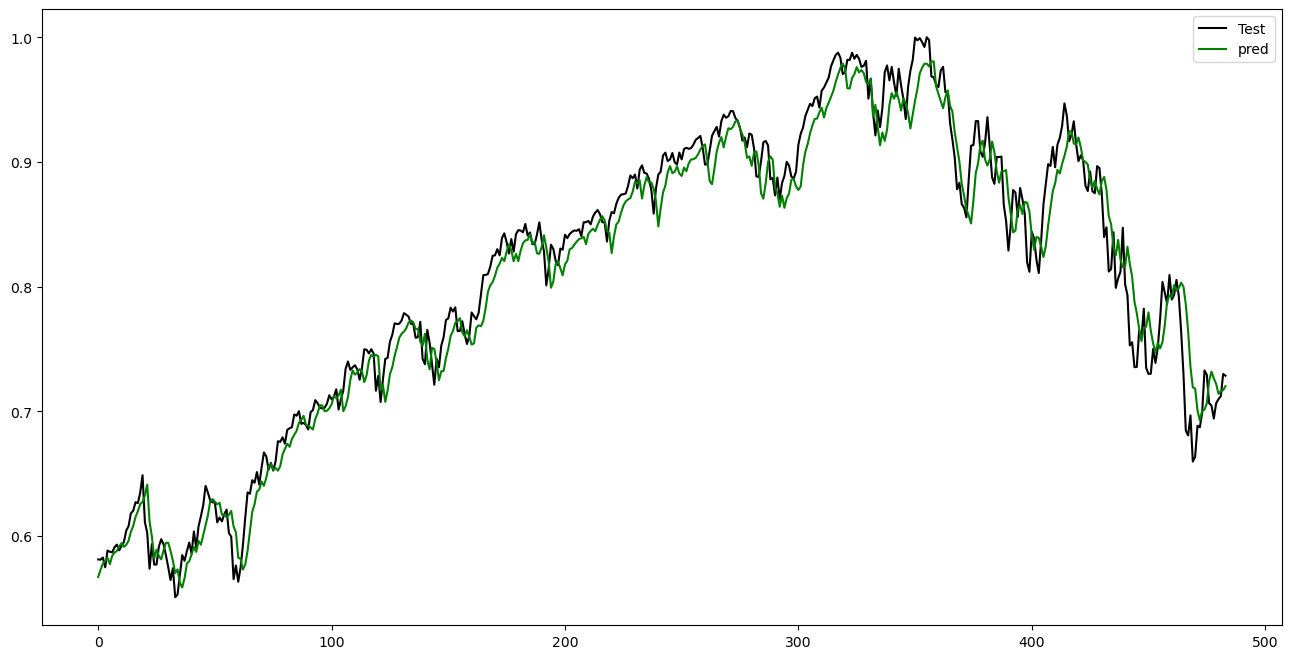

In [17]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

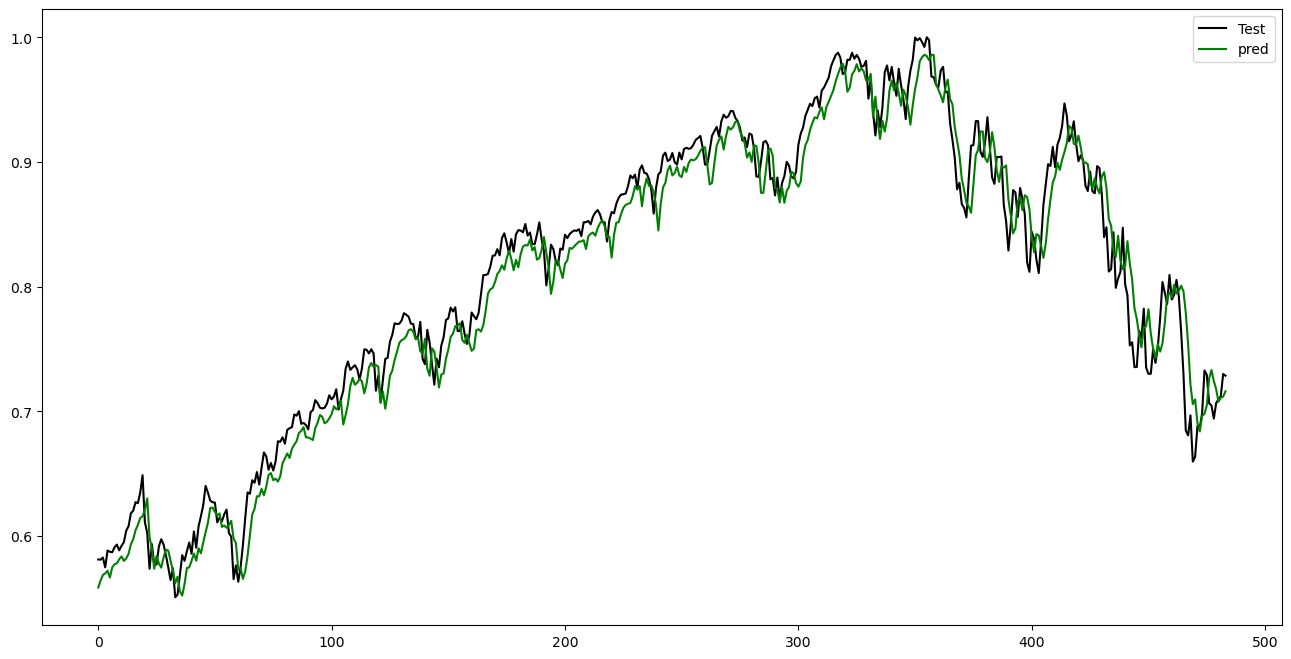

In [20]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()